# Exercício 1 - Lista Final - Fundamentos de Redes Neurais e Aprendizado Estatístico

Imports:

In [108]:
from tensorflow.keras.datasets import cifar10
from sklearn.decomposition import KernelPCA, PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np
import cv2

np.random.seed(42) # setando semente

### Pré Processamento

Carregando conjunto de dados:

In [109]:
(data_train, label_train), (data_test, label_test) = cifar10.load_data()

# concatena os dados
x_all = np.concatenate((data_train, data_test), axis=0)
y_all = np.concatenate((label_train, label_test), axis=0)

Filtrando para apenas carros e aviões:

In [110]:
categories = [0, 1]  # airplane, car
train_filter = np.isin(y_all, categories)

x_filt, y_filt = x_all[train_filter.flatten()], y_all[train_filter.flatten()]

Plotando imagem:

In [111]:
# função para plotar imagem exemplo posteriormente
def plot_image(img, title):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

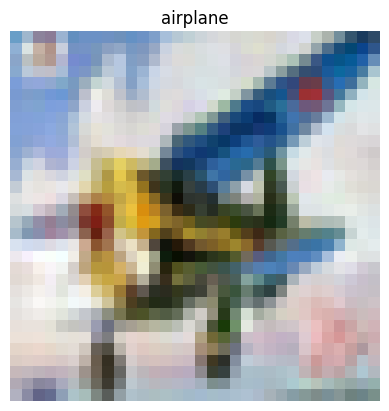

In [112]:
category_labels = {0: 'airplane', 1: 'car'}
num_imagem = 1254
example_image = x_filt[num_imagem]
example_label = y_filt[num_imagem][0]

plot_image(example_image, category_labels[example_label])

Convertendo para cinza:

In [113]:
def convert_to_gray(images):
    gray_images = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images])
    return gray_images

In [114]:
x_all_gray = convert_to_gray(x_filt)

Vetorizando:

In [115]:
x_all_gray_flattened = x_all_gray.reshape(x_all_gray.shape[0], -1)

Conferindo formato:

In [116]:
print(f'Formato original das imagens: {x_filt.shape[1:]}')
print(f'Formato das imagens após conversão para cinza: {x_all_gray.shape[1:]}')
print(f'Formato das imagens vetorizadas: {x_all_gray_flattened.shape[1]}')

Formato original das imagens: (32, 32, 3)
Formato das imagens após conversão para cinza: (32, 32)
Formato das imagens vetorizadas: 1024


Limitando o conjunto de dados:

In [117]:
x_all_gray_flattened.shape

(12000, 1024)

In [118]:
sample_size = 0.1
X_sample, _, y_sample, _ = train_test_split(x_all_gray_flattened, y_filt, test_size=1-sample_size, random_state=42)
X_sample.shape

(1200, 1024)

Dividindo dados e embaralhando:

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=42, shuffle=True)

Olhando a distribuição do conjunto de testes:

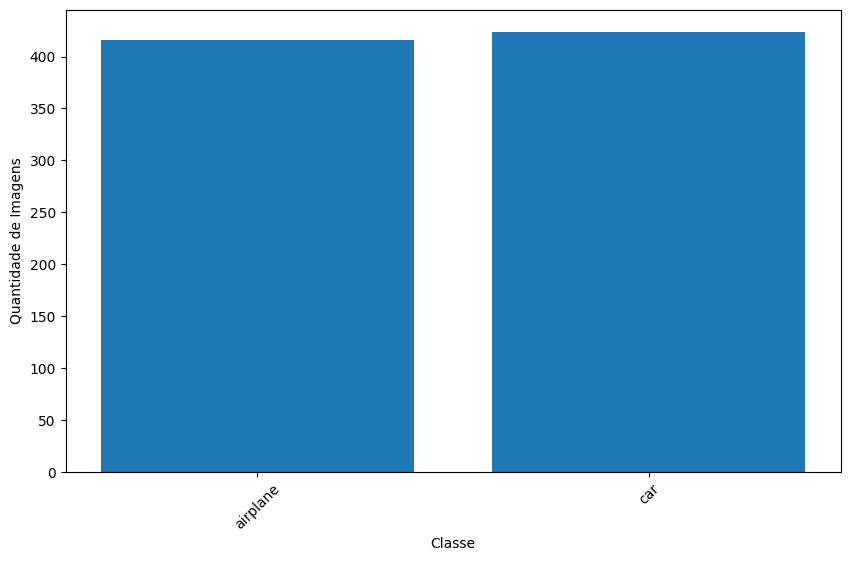

In [125]:
# Conta a quantidade de imagens para cada classe no conjunto de treinamento
unique, counts = np.unique(y_train, return_counts=True)
class_counts = dict(zip(unique, counts))

# Plotar o histograma
class_names = ['airplane', 'car']

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), tick_label=class_names)
plt.xlabel('Classe')
plt.ylabel('Quantidade de Imagens')
#plt.title('Quantidade de Imagens por Classe no Conjunto de Treinamento Fashion')
plt.xticks(rotation=45)
plt.show()

### Realização do KPCA

Escalando dados:

In [120]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)

Aplicando KPCA:

In [121]:
kpca = KernelPCA(kernel='poly', gamma=0.1, n_components=2)  # Usando kernel polinomial
x_train_kpca = kpca.fit_transform(x_train_scaled)

Visualizando dados na dimensão reduziada:

In [122]:
def plot_kpca(x, y, title):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(x[:, 0], x[:, 1], c=y.ravel(), cmap='viridis', s=10)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

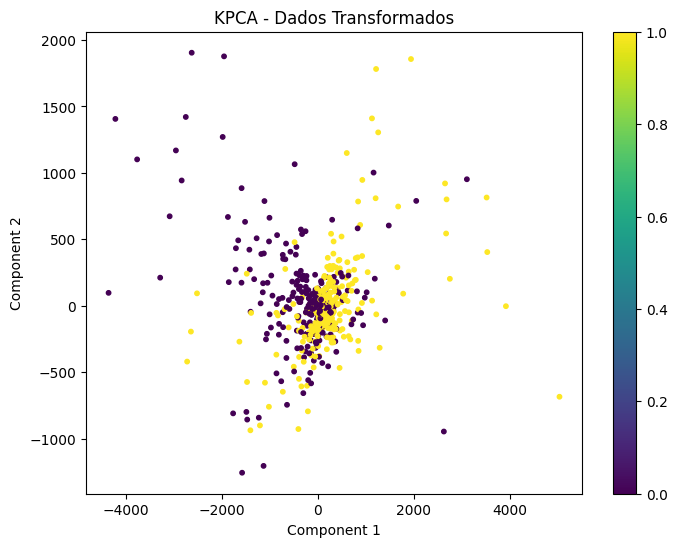

In [123]:
plot_kpca(x_train_kpca, y_train, 'KPCA - Dados Transformados')

### Aplicando SVM linear

Treinando modelo:

In [124]:
kf1 = KFold(n_splits=4, shuffle=True, random_state=42)

# lista para armazenar os modelos
svm_linear = []

# itera sobre cada fold
for train_index, test_index in kf1.split(x_train_kpca):
    
    X_train, X_val = x_train_kpca[train_index], x_train_kpca[test_index]
    y_train2, y_val = y_train[train_index], y_train[test_index]
    
    # cria e treinar o modelo SVM
    clf_linear = SVC(kernel='linear', C=1.0)
    clf_linear.fit(X_train, y_train2.ravel())

    svm_linear.append(clf_linear)
    
    # avalia o modelo no conjunto de validação
    accuracy = clf_linear.score(X_val, y_val)
    print(f"Acurácia no fold: {accuracy:.2f}")


Acurácia no fold: 0.62
Acurácia no fold: 0.52
Acurácia no fold: 0.62
Acurácia no fold: 0.64


Visualizando reta de decisão obtida:

In [126]:
def plot_decision_boundary(clf, X, y, title):
    h = 3  # Tamanho do passo da malha
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='viridis')
    plt.title(title)
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.show()

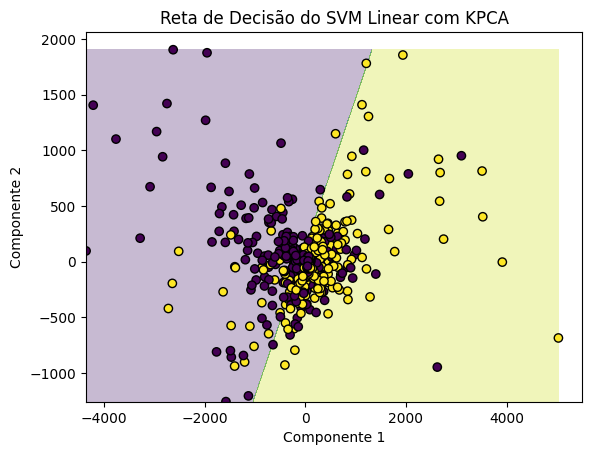

In [127]:
plot_decision_boundary(svm_linear[3], x_train_kpca, y_train, 'Reta de Decisão do SVM Linear com KPCA')

### Aplicando PCA

In [128]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_scaled)

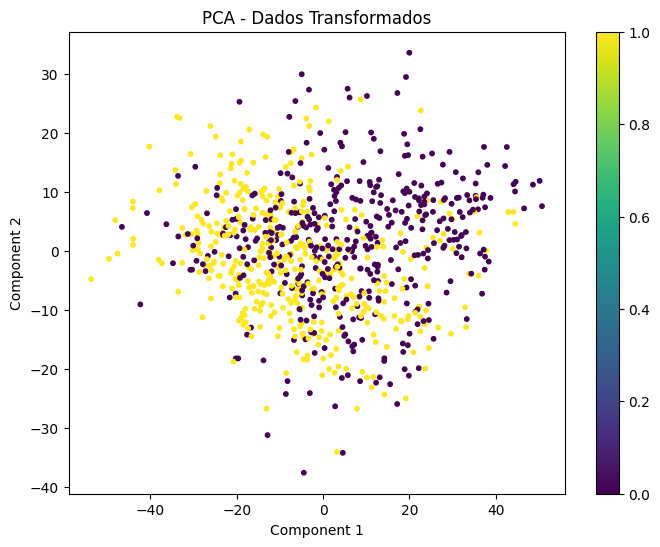

In [129]:
plot_kpca(x_train_pca, y_train, 'PCA - Dados Transformados')

### Aplicando Kernel SVM

Acurácia no fold: 0.66


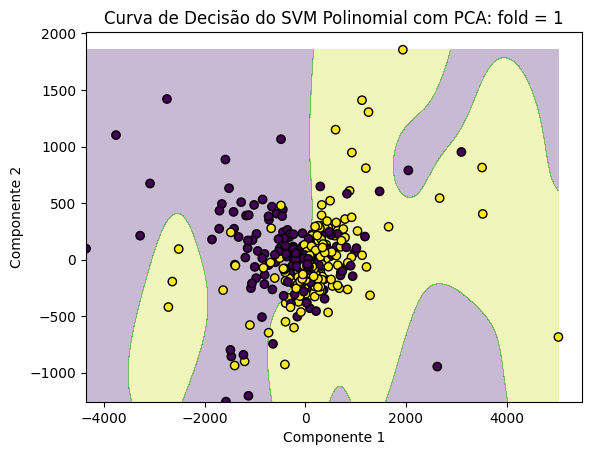

Acurácia no fold: 0.56


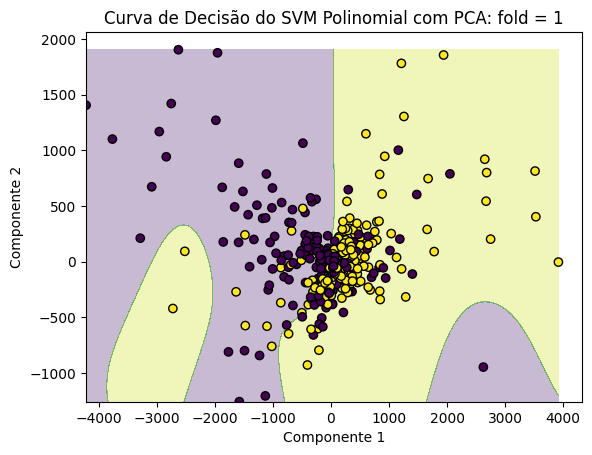

Acurácia no fold: 0.64


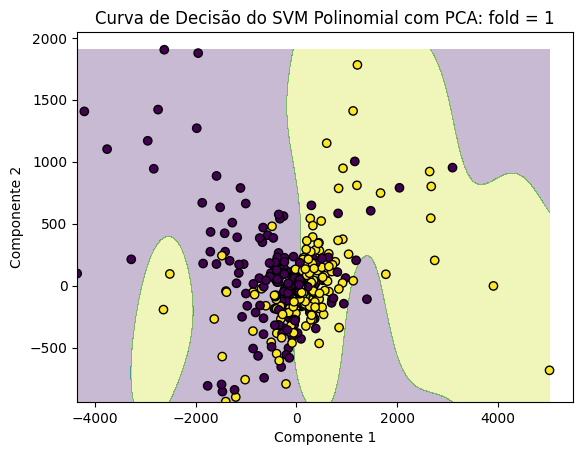

Acurácia no fold: 0.67


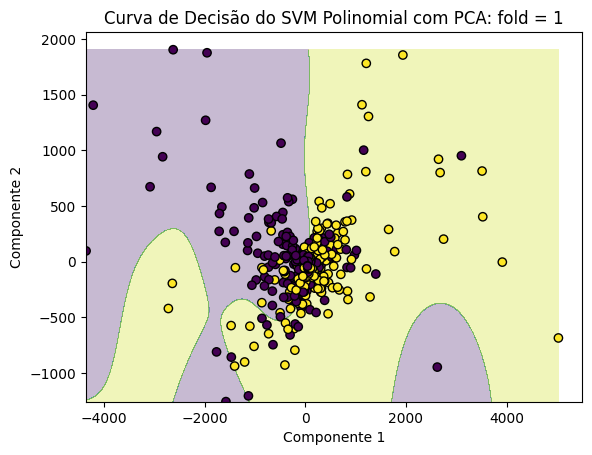

In [143]:
kf2 = KFold(n_splits=4, shuffle=True, random_state=42)

# lista para armazenar os modelos
svm_kernel = []

# itera sobre cada fold
for train_index, test_index in kf2.split(x_train_pca):
    
    X_train, X_val = x_train_kpca[train_index], x_train_kpca[test_index]
    y_train2, y_val = y_train[train_index], y_train[test_index]
    
    # cria e treinar o modelo SVM
    clf_kernel = SVC(kernel='rbf', C=1.0)
    clf_kernel.fit(X_train, y_train2.ravel())

    svm_kernel.append(clf_kernel)
    
    # avalia o modelo no conjunto de validação
    accuracy = clf_kernel.score(X_val, y_val)
    print(f"Acurácia no fold: {accuracy:.2f}")
    i = 1
    plot_decision_boundary(clf_kernel, X_train, y_train2, f'Curva de Decisão do SVM Polinomial com PCA: fold = {i}')
    i = i + 1

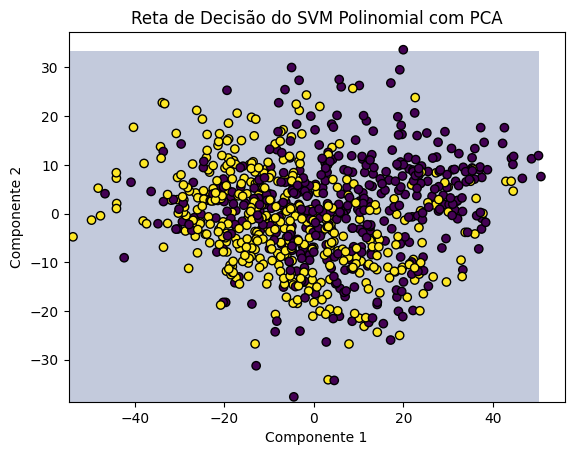

In [141]:
plot_decision_boundary(svm_kernel[3], x_train_pca, y_train, 'Reta de Decisão do SVM Polinomial com PCA')